# AIPI 590 - XAI | Assignment #1
### Interpretable ML
### Mu Niu


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mu-niu13/AIPI-590-XAI-Interpretable-ML/blob/main/main.ipynb#scrollTo=jehWgiVqrux_)

#### Import Libs

In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# stats test and model
from scipy import stats
from scipy.stats import shapiro, jarque_bera, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from pygam import LinearGAM, LogisticGAM, s, f
from pygam.terms import TermList

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#### Connect to Github Repo

In [5]:
# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI-Interpretable-ML" # Change to your repo name
git_path = 'https://github.com/Mu-niu13/AIPI-590-XAI-Interpretable-ML.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'templates'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

Cloning into 'AIPI-590-XAI-Interpretable-ML'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (13/13), 166.34 KiB | 2.25 MiB/s, done.
Resolving deltas: 100% (3/3), done.
[Errno 2] No such file or directory: 'AIPI-590-XAI-Interpretable-ML/templates'
/content
AIPI-590-XAI-Interpretable-ML/  sample_data/


#### Load Data

In [6]:
data = pd.read_csv('AIPI-590-XAI-Interpretable-ML//data.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 1. Exploratory Data Analysis to Check Assumptions

#### 1.1 Data Preprocessing

In [7]:
# fill empty string in total charges with median
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

# convert categorical to numerical
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}

for col in categorical_columns:
    if col != 'Churn':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# binary target variable
data['Churn_binary'] = (data['Churn'] == 'Yes').astype(int)
data['Churn_continuous'] = data['Churn_binary'].astype(float)

/tmp/ipython-input-2298709191.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


In [8]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
feature_columns = [col for col in data.columns if col not in ['Churn', 'Churn_binary', 'Churn_continuous', 'customerID']]

X = data[feature_columns]
y_continuous = data['Churn_continuous']
y_binary = data['Churn_binary']

# split data
X_train, X_test, y_train_cont, y_test_cont = train_test_split(X, y_continuous, test_size=0.2, random_state=42)
_, _, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42)

1.2.1 Linearity

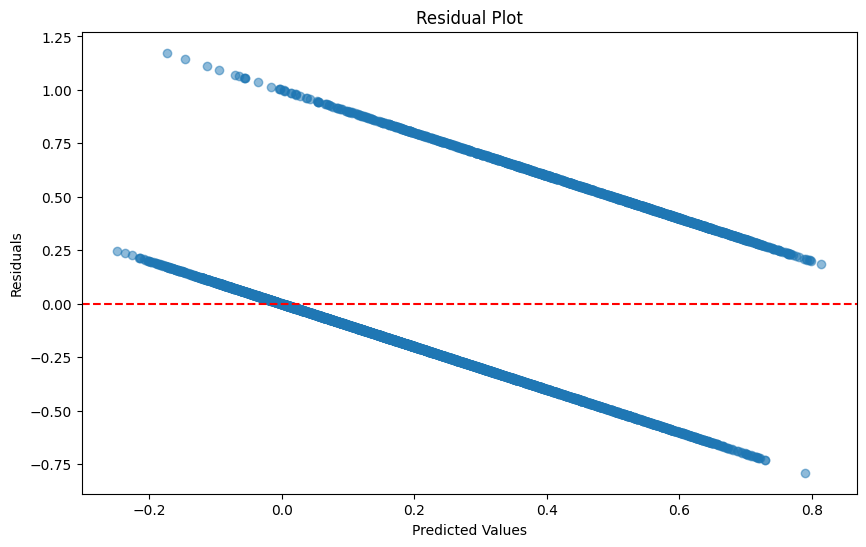

In [9]:
# Fit initial linear model for residual analysis
linear_model = LinearRegression()
linear_model.fit(X_train, y_train_cont)
y_pred_train = linear_model.predict(X_train)
residuals = y_train_cont - y_pred_train

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The residual plot is not ramdom cloud/scattered points so the linearity assumption is violated.

1.2.2 Independence of Observations

In [10]:
dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic:.4f}")

Durbin-Watson statistic: 1.9990


The Durbin-Watson test gives a value of 1.999, which is indicative of no autocorrelation

1.2.3 Homoscedasticity

In [11]:
X_with_const = sm.add_constant(X_train)
bp_test = het_breuschpagan(residuals, X_with_const)
bp_statistic, bp_pvalue, bp_fstatistic, bp_f_pvalue = bp_test

print(f"LM statistic: {bp_statistic:.4f}")
print(f"p-value: {bp_pvalue:.4f}")

LM statistic: 1124.7716
p-value: 0.0000


The residual plot we did earlier already indicate violation of homoscedasticity assumption. Here, the Breusch-Pagan test has p value < 0.05, which again suggests heteroscedasticity.

1.2.4 Normality of Residuals

In [12]:
jb_stat, jb_p = jarque_bera(residuals)

print(f"Jarque-Bera Test: {jb_stat:.4f}, p-value: {jb_p:.4f}")

Jarque-Bera Test: 352.2300, p-value: 0.0000


The Jarque-Bera Test has p value < 0.05, which suggests non-normal residuals.

1.2.5 No Multicollinearity

In [13]:
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

print("Variance Inflation Factors:")
print(vif_data.sort_values('VIF', ascending=False))


Variance Inflation Factors:
             Feature        VIF
17    MonthlyCharges  20.513778
5       PhoneService  15.112905
4             tenure  14.708985
18      TotalCharges  13.799333
7    InternetService   4.345274
14          Contract   4.161058
13   StreamingMovies   3.270139
12       StreamingTV   3.239720
16     PaymentMethod   3.089833
15  PaperlessBilling   2.867544
2            Partner   2.826833
6      MultipleLines   2.797471
10  DeviceProtection   2.635776
9       OnlineBackup   2.461293
11       TechSupport   2.383184
8     OnlineSecurity   2.227453
0             gender   1.976463
3         Dependents   1.956171
1      SeniorCitizen   1.364272


The VIF test shows multicollinarity between Monthly Charges, Phone Service, Tenure, and Total Charges.

1.2.6 No Influential Outliers

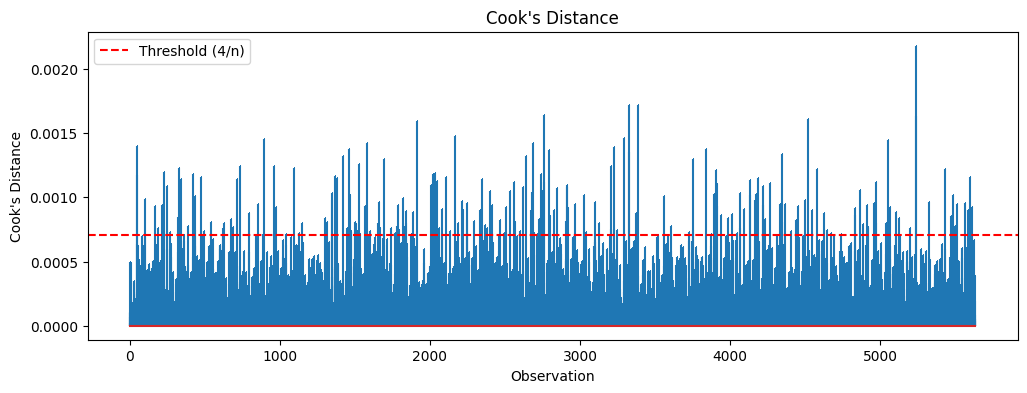

In [14]:
# Cook's distance calculation
linear_model_sm = ols('Churn_continuous ~ ' + ' + '.join(X_train.columns),
                     data=pd.concat([X_train, y_train_cont], axis=1)).fit()

influence = linear_model_sm.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(12, 4))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.xlabel('Observation')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance")
plt.axhline(y=4/len(cooks_d), color='r', linestyle='--', label='Threshold (4/n)')
plt.legend()

Many observations have cook's distance greater than the threshold of 4/n, which indicates violation of No Influential Outliers assumption.

## 2. Linear Regression

In [15]:
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_cont)

# pred
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# clip predictions to [0, 1] range
y_pred_lr_train_clipped = np.clip(y_pred_lr_train, 0, 1)
y_pred_lr_test_clipped = np.clip(y_pred_lr_test, 0, 1)

# model performance
lr_train_r2 = r2_score(y_train_cont, y_pred_lr_train)
lr_test_r2 = r2_score(y_test_cont, y_pred_lr_test)

print(f"Training R2: {lr_train_r2:.4f}")
print(f"Test R2: {lr_test_r2:.4f}")

Training R2: 0.2684
Test R2: 0.3030


The R sqaure told us that the model performance is not ideal for liner regression.

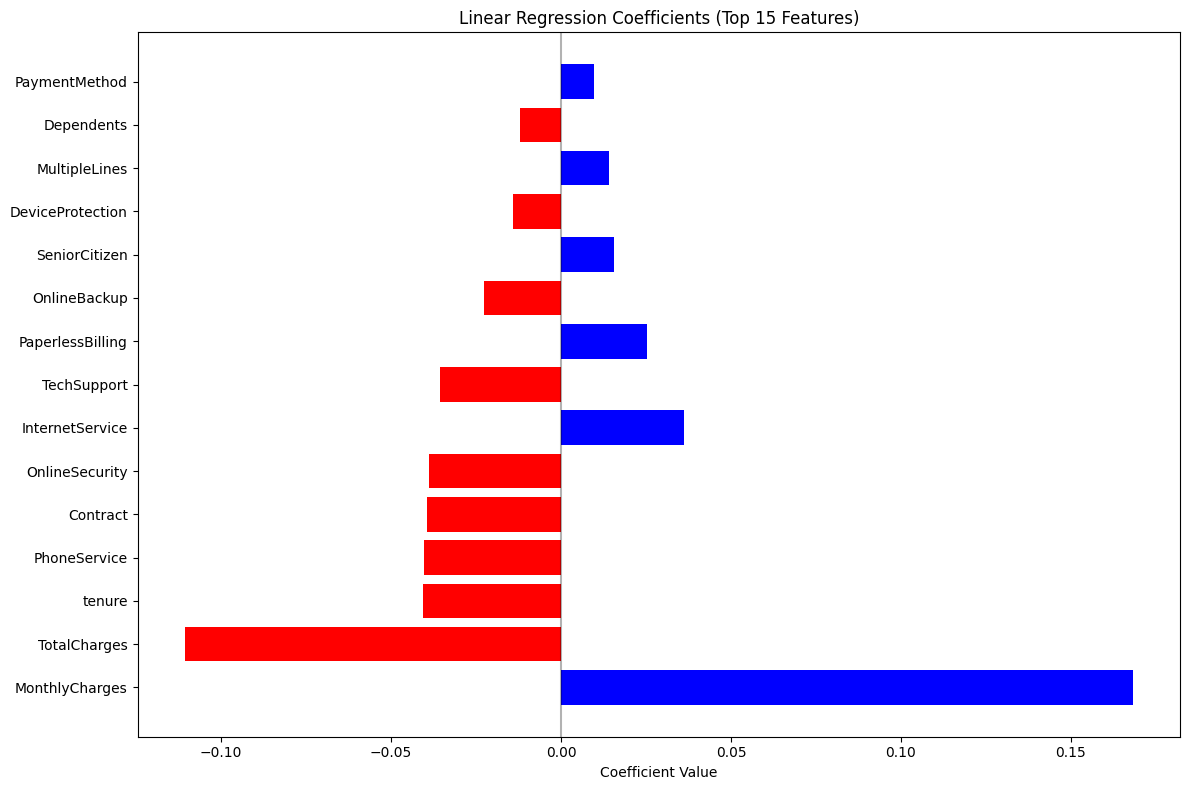

In [16]:
# create dataframe
lr_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

# visualize coefficients
plt.figure(figsize=(12, 8))
top_features = lr_coefficients.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Linear Regression Coefficients (Top 15 Features)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

From the coefficients plot above, we can see that the customer loyalty features, like tenure, total charges, extra services lead to lower churn. High recurring cost, like monthly charges increases churn. Certain service types, including internet service and paperless billing are related to higher churn risk.

## 3. Logistic Regression

In [17]:
# fit
logit_model = LogisticRegression(random_state=590, max_iter=1000)
logit_model.fit(X_train_scaled, y_train_bin)

# pred
y_pred_logit_train = logit_model.predict(X_train_scaled)
y_pred_logit_test = logit_model.predict(X_test_scaled)
y_pred_logit_train_proba = logit_model.predict_proba(X_train_scaled)[:, 1]
y_pred_logit_test_proba = logit_model.predict_proba(X_test_scaled)[:, 1]

# model performance
logit_train_auc = roc_auc_score(y_train_bin, y_pred_logit_train_proba)
logit_test_auc = roc_auc_score(y_test_bin, y_pred_logit_test_proba)


print(f"Training AUC: {logit_train_auc:.4f}")
print(f"Test AUC: {logit_test_auc:.4f}")

Training AUC: 0.8428
Test AUC: 0.8614


The AUC shows that logistic regression has strong and robust performance on predicitng customer churning.

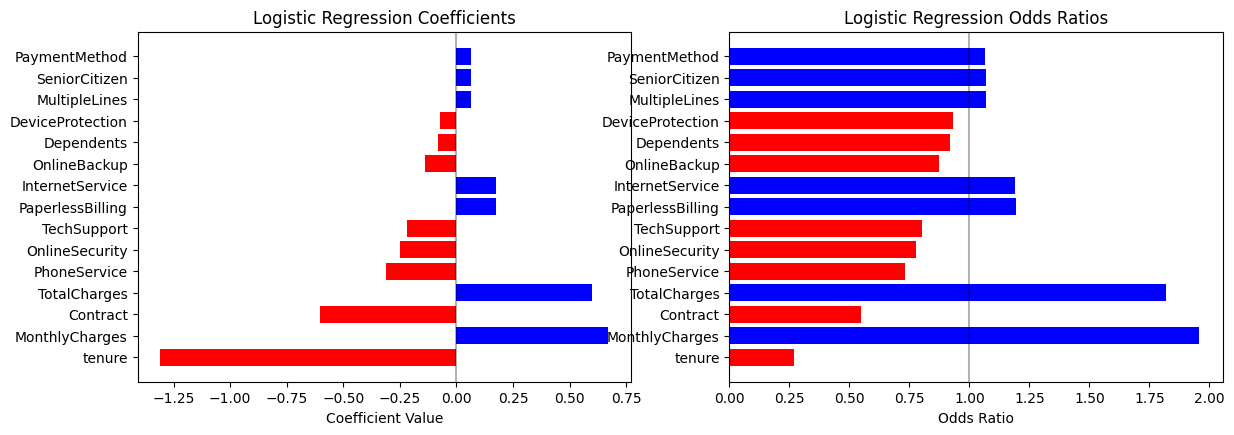

In [18]:
# create dataframe
logit_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': logit_model.coef_[0],
    'Odds_Ratio': np.exp(logit_model.coef_[0]),
    'Abs_Coefficient': np.abs(logit_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

# visualize coefficients
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
top_features = logit_coefficients.head(15)
colors = ['red' if x < 0 else 'blue' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)

plt.subplot(2, 2, 2)
colors = ['red' if x < 1 else 'blue' for x in top_features['Odds_Ratio']]
plt.barh(range(len(top_features)), top_features['Odds_Ratio'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Odds Ratio')
plt.title('Logistic Regression Odds Ratios')
plt.axvline(x=1, color='black', linestyle='-', alpha=0.3)

The plot above shows that higher monthly charges strongly increase churn risk, while longer tenure and higher total charges greatly reduce it. Features like paperless billing and internet service slightly increase churn, whereas tech support, online security, and phone service lower churn.

## 4. Generalized Additive Model (GAM)

In [26]:
# use original unscaled features
continuous_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = [col for col in X_train.columns if col not in continuous_features]
feature_indices = {col: i for i, col in enumerate(X_train.columns)}

# build GAM terms
gam_terms = []
for i, col in enumerate(X_train.columns):
    if col in continuous_features:
        gam_terms.append(s(i, n_splines=10))
    else:
        gam_terms.append(f(i))

term_list = TermList(*gam_terms)

# fit
gam_model = LogisticGAM(terms=term_list, max_iter=100)
gam_model.fit(X_train.values, y_train_bin)

# pred
y_pred_gam_train_proba = gam_model.predict_proba(X_train.values)
y_pred_gam_test_proba = gam_model.predict_proba(X_test.values)
y_pred_gam_train = (y_pred_gam_train_proba > 0.5).astype(int)
y_pred_gam_test = (y_pred_gam_test_proba > 0.5).astype(int)

# model performance
gam_train_auc = roc_auc_score(y_train_bin, y_pred_gam_train_proba)
gam_test_auc = roc_auc_score(y_test_bin, y_pred_gam_test_proba)

print(f"Training AUC: {gam_train_auc:.4f}")
print(f"Test AUC: {gam_test_auc:.4f}")

Training AUC: 0.8516
Test AUC: 0.8622


The AUC shows that GAM has strong and robust performance on predicitng customer churning, and has similar performance as logistic regression.

In [37]:
# drop intercept
p_values = np.array(gam_model.statistics_['p_values'])[1:]

# map term index to feature name
feature_names = list(X_train.columns)
term_labels = []
for i, term in enumerate(gam_model.terms):
    if not term.isintercept:
        term_labels.append(feature_names[term.feature])

# create dataframe
importance_df = pd.DataFrame({
    'Feature': term_labels,
    'P_value': p_values
}).sort_values('P_value')

# print
for _, row in importance_df.head(15).iterrows():
    print(f"{row['Feature']:<25}  p={row['P_value']:.2e}")


StreamingMovies            p=2.78e-15
Dependents                 p=4.78e-10
TotalCharges               p=1.29e-08
InternetService            p=2.17e-07
DeviceProtection           p=2.01e-05
PhoneService               p=7.17e-05
Contract                   p=1.53e-04
OnlineSecurity             p=6.28e-04
PaperlessBilling           p=1.55e-03
MultipleLines              p=2.01e-03
StreamingTV                p=1.61e-02
PaymentMethod              p=2.07e-02
OnlineBackup               p=2.65e-02
TechSupport                p=4.19e-02
gender                     p=1.75e-01


The GAM result above shows that streaming movies, dependents, total charges, internet service, and device protection are the most statistically significant predictors of churn.

## 5. Model Comparison

Model predictive performance:
- Linear Regression < Logistic Regression ≈ GAM

Model interpretability:
- GAM < Logistic Regression < Linear Regression

Linear regression is simple and fast. Its coefficients are straightforward to interpret. But our dataset violates many assumptions, and it is theoretically inappropriate for binary outcomes.

Logistic regression is appropriate for binary classification. It has good balance of performance and interpretability. But it assumes a linear relationship between predictors and log-odds, missing non-linear patterns, sensitivity to outliers, and requiring certain error distribution assumptions.

GAM can learn non-linear relationships automatically while being relatively interpretable. It flexibly models both continuous and categorical variables and allows visual inspection of feature effects. However, it is more complex to implement and maintain.

Overall, logistic regression is recommended because it provides the best balance of predictive performance and interpretability.